In [1]:
import os
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from keras.models import Model, load_model
from keras.layers import Dense, Input, Conv2D, MaxPool2D, Flatten
from keras.preprocessing.image import ImageDataGenerator
np.random.seed(22)

2023-02-02 11:17:46.144034: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-02 11:17:46.223524: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-02 11:17:46.225918: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/nsl47/anaconda3/envs/bd/lib/python3.10/site-packages/cv2/../../../../lib:
202

In [2]:
def load_normal(norm_path):
    norm_files = np.array(os.listdir(norm_path))
    norm_labels = np.array(['normal']*len(norm_files))
    
    norm_images = []
    for image in tqdm(norm_files):
        image = cv2.imread(norm_path + image)
        image = cv2.resize(image, dsize=(200,200))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        norm_images.append(image)
        
    norm_images = np.array(norm_images)
    
    return norm_images, norm_labels

def load_pneumonia(pneu_path):
    pneu_files = np.array(os.listdir(pneu_path))
    pneu_labels = np.array([pneu_file.split('_')[1] for pneu_file in pneu_files])
    
    pneu_images = []
    for image in tqdm(pneu_files):
        image = cv2.imread(pneu_path + image)
        image = cv2.resize(image, dsize=(200,200))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        pneu_images.append(image)
        
    pneu_images = np.array(pneu_images)
    
    return pneu_images, pneu_labels

In [3]:
norm_images, norm_labels = load_normal('chest_xray/train/NORMAL/')
pneu_images, pneu_labels = load_pneumonia('chest_xray/train/PNEUMONIA/')

100%|████████████████████████████████████████████████████| 3875/3875 [00:16<00:00, 230.01it/s]


In [4]:
X_train = np.append(norm_images, pneu_images, axis=0)
y_train = np.append(norm_labels, pneu_labels)

In [5]:
X_train.shape

(5216, 200, 200)

In [6]:
y_train.shape

(5216,)

In [7]:
np.unique(y_train, return_counts=True)

(array(['bacteria', 'normal', 'virus'], dtype='<U8'),
 array([2530, 1341, 1345]))

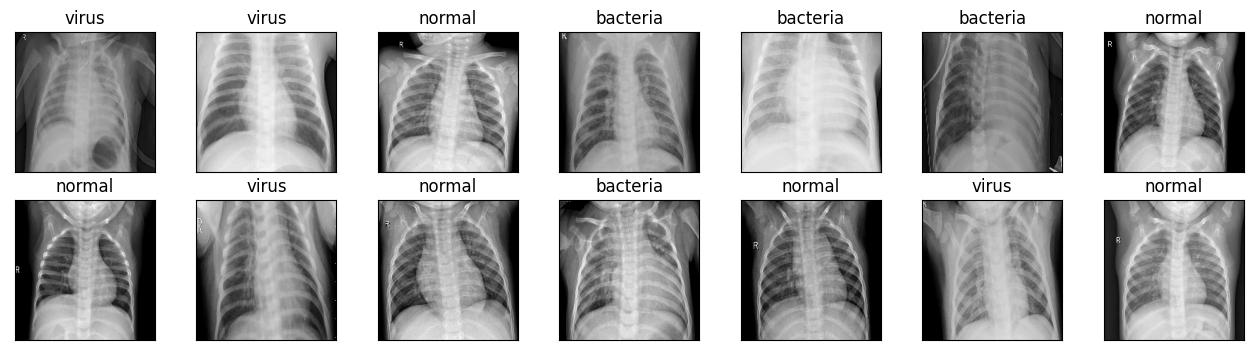

In [9]:
fig ,axes = plt.subplots(ncols =7 ,nrows=2 , figsize =(16,4))

indices = np.random.choice(len(X_train),14)

counter = 0

for i in range(2):
    for j in range(7):
        axes[i,j].set_title(y_train[indices[counter]])
        axes[i,j].imshow(X_train[indices[counter]], cmap='gray')
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        counter += 1
        
plt.show()


In [10]:
norm_images_test, norm_labels_test = load_normal('chest_xray/test/NORMAL/')
pneu_images_test, pneu_labels_test = load_pneumonia('chest_xray/test/PNEUMONIA/')

100%|██████████████████████████████████████████████████████| 390/390 [00:01<00:00, 274.89it/s]


In [11]:
X_test = np.append(norm_images_test, pneu_images_test, axis=0)
y_test = np.append(norm_labels_test, pneu_labels_test)

In [12]:
# Use this to save variables
with open('pneumonia_data.pickle', 'wb') as f:
    pickle.dump((X_train, X_test, y_train, y_test), f)
# Use this to load variables
with open('pneumonia_data.pickle', 'rb') as f:
    (X_train, X_test, y_train, y_test) = pickle.load(f)

In [13]:
y_train = y_train[:, np.newaxis]
y_test = y_test[:, np.newaxis]

In [14]:
one_hot_encoder = OneHotEncoder(sparse=False)


In [15]:
y_train_one_hot = one_hot_encoder.fit_transform(y_train)
y_test_one_hot = one_hot_encoder.transform(y_test)


In [16]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

In [17]:
datagen = ImageDataGenerator(
        rotation_range = 10,  
        zoom_range = 0.1, 
        width_shift_range = 0.1, 
        height_shift_range = 0.1)

In [18]:
datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train_one_hot, batch_size=32)

In [19]:
input1 = Input(shape=(X_train.shape[1], X_train.shape[2], 1))

cnn = Conv2D(16, (3, 3), activation='relu', strides=(1, 1), 
    padding='same')(input1)
cnn = Conv2D(32, (3, 3), activation='relu', strides=(1, 1), 
    padding='same')(cnn)
cnn = MaxPool2D((2, 2))(cnn)

cnn = Conv2D(16, (2, 2), activation='relu', strides=(1, 1), 
    padding='same')(cnn)
cnn = Conv2D(32, (2, 2), activation='relu', strides=(1, 1), 
    padding='same')(cnn)
cnn = MaxPool2D((2, 2))(cnn)

cnn = Flatten()(cnn)
cnn = Dense(100, activation='relu')(cnn)
cnn = Dense(50, activation='relu')(cnn)

output1 = Dense(3, activation='softmax')(cnn)

model = Model(inputs=input1, outputs=output1)

2023-02-02 11:39:45.283591: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/nsl47/anaconda3/envs/bd/lib/python3.10/site-packages/cv2/../../../../lib:
2023-02-02 11:39:45.283771: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-02 11:39:45.283790: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (nsl47): /proc/driver/nvidia/version does not exist
2023-02-02 11:39:45.284462: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFl

In [20]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', metrics=['acc'])

In [21]:
history = model.fit_generator(train_gen, epochs=30, 
          validation_data=(X_test, y_test_one_hot))

Epoch 1/30


/tmp/ipykernel_169993/969928468.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen, epochs=30,


163/163 [==============================] - 42s 252ms/step - loss: 1.0868 - acc: 0.6683 - val_loss: 0.7035 - val_acc: 0.7885
Epoch 2/30
163/163 [==============================] - 41s 249ms/step - loss: 0.6430 - acc: 0.7316 - val_loss: 0.7204 - val_acc: 0.7580
Epoch 3/30
163/163 [==============================] - 41s 250ms/step - loss: 0.6117 - acc: 0.7373 - val_loss: 1.0425 - val_acc: 0.6971
Epoch 4/30
163/163 [==============================] - 41s 250ms/step - loss: 0.5878 - acc: 0.7552 - val_loss: 0.7313 - val_acc: 0.7788
Epoch 5/30
163/163 [==============================] - 41s 251ms/step - loss: 0.5784 - acc: 0.7554 - val_loss: 0.8633 - val_acc: 0.8077
Epoch 6/30
163/163 [==============================] - 41s 251ms/step - loss: 0.5555 - acc: 0.7653 - val_loss: 1.0793 - val_acc: 0.7388
Epoch 7/30
163/163 [==============================] - 41s 250ms/step - loss: 0.5536 - acc: 0.7665 - val_loss: 0.9121 - val_acc: 0.7099
Epoch 8/30
163/163 [==============================] - 41s 252ms/st

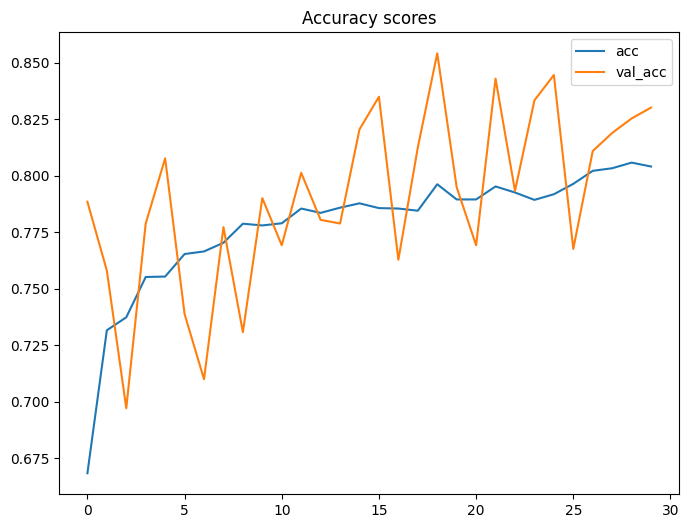

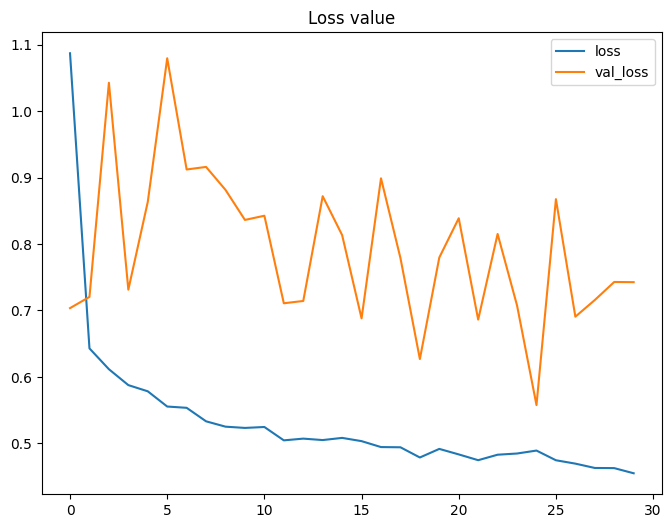

In [23]:
plt.figure(figsize=(8,6))
plt.title('Accuracy scores')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.show()

plt.figure(figsize=(8,6))
plt.title('Loss value')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [ ]:
#Model evaluation


In [24]:
predictions = model.predict(X_test)
predictions = one_hot_encoder.inverse_transform(predictions)

20/20 [==============================] - 3s 120ms/step


In [25]:
cm = confusion_matrix(y_test, predictions)


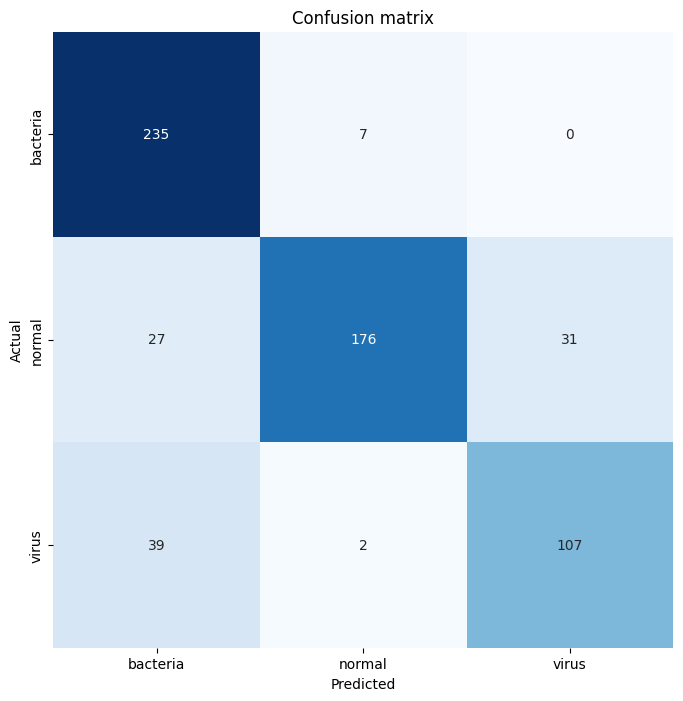

In [27]:
classnames = ['bacteria', 'normal', 'virus']
plt.figure(figsize=(8,8))
plt.title('Confusion matrix')
sns.heatmap(cm, cbar=False, xticklabels=classnames, yticklabels=classnames, fmt='d', annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# More Explain 
https://www.analyticsvidhya.com/blog/2020/09/pneumonia-detection-using-cnn-with-implementation-in-python/